# New Conventions for DataFrame

In order to save space and create a more accurate dataframe representing only ternaries, we created the following new Dataframe (known as DataFrame2):

Rules: We only include entries from the icsd-ternaries.dat csv file which have unique compositions and for which l+m+n=integer less than 100 where the formula is denoted by ($P_lQ_mR_n$).

We also define a new feature vector having the dimensions ((nsmaples $\times$ nfeatures), where:

    nsamples: Number of unique ternary compounds defined by Rules
    
    nfeatures:  columns 0:2: Atomic number of P,Q,R.
                columns 3:5: l,m,n respectively
                columns 6:8: Electronegativity of P,Q,R.
                column  9: Space Group number
                

In [1]:
import numpy as np

In [2]:
#Reading data file
import csv
with open('ICSD/Unique_ICSD.dat','r') as f:
            data_1=csv.reader(f,"excel-tab")
            list_data1=[[element.strip() for element in row] for row in data_1]
for row1 in list_data1:
    row1[1]=row1[1].replace(' ','')
list_space=[row1[1].rstrip('Z').rstrip('S').rstrip("H").rstrip('R') for row1 in list_data1]

In [3]:
from pymatgen.matproj.rest import MPRester
from pymatgen.core import Element, Composition

In [4]:
#Forming vocabulary of Elements including Deutorium and Tritium
element_universe = [str(e) for e in Element]
dict_element={}
for i,j in enumerate(element_universe):
    dict_element[str(j)]=i
dict_element['D']=103
dict_element['T']=104    

In [14]:
# Creating arrays for atomic number, stoichiometry and electronegativities
stoich_array=np.zeros((len(list_data1),3),dtype=float)
at_num_array=np.zeros((len(list_data1),3),dtype=float)
electroneg_array=np.zeros((len(list_data1),3),dtype=float)
for index,entry in enumerate(list_data1):
    comp=Composition(entry[2])
    temp_dict=dict(comp.get_el_amt_dict())
    for count,key in enumerate(temp_dict.keys()):
        stoich_array[index][count]= temp_dict[key]
        if key not in ['D','T']: 
            at_num_array[index][count]=Element(key).Z
            electroneg_array[index][count]=Element(key).X
        else:
            at_num_array[index][count]=Element('H').Z
            electroneg_array[index][count]=Element('H').X

In [15]:
stoich_array[0],at_num_array[0],electroneg_array[0],list_data1[0][2]

(array([ 1.,  6.,  8.]),
 array([ 32.,  52.,  47.]),
 array([ 2.01,  2.1 ,  1.93]),
 'Ag8 Ge Te6')

In [16]:
# Building Spacegroup dictionary
with open("ICSD/spacegroups.dat",'r') as f:
    dat=csv.reader(f,dialect='excel-tab',quoting=csv.QUOTE_NONE)
    list_dat=[element.strip() for row in dat for element in row ]
    list1=[[int(list_dat[i*2]),list_dat[i*2+1]] for i in range(int(len(list_dat)/2))]
dict_space={}
for i in range(len(list1)):
    dict_space[list1[i][1]]=list1[i][0]
with open('ICSD/spacegroups_2.dat','r') as f1:
        f=f1.readlines()
        for line in f:
            data2=[element.strip() for element in line.split()]
            if data2[1] not in dict_space.keys():
                dict_space[data2[1]]=int(data2[0])
                
with open('ICSD/spacegroups_3.dat','r') as f1:
        f=f1.readlines()
        for line in f:
            data3=[element.strip() for element in line.split()]
            if data3[0] not in dict_space.keys():
                dict_space[data3[0]]=int(data3[1]) 

In [17]:
#creating spacegroup array
space_num_array=np.zeros(len(list_space),dtype=float)
for i,s in enumerate(list_space):    
        space_num_array[i]=dict_space[s]

In [45]:
#Joining all the arrays
Dataframe_all=np.hstack((at_num_array,stoich_array,electroneg_array,space_num_array[:,np.newaxis]))

In [78]:
#Adding constraints defined in Rules above
Dataframe_temp=Dataframe_all[(np.sum(Dataframe_all[:,3:6],axis=1)<100 )]
Dataframe2=Dataframe_temp[(np.all(np.mod(Dataframe_temp[:,3:6],1)==0,axis=1))]


In [83]:
#Saving the data as dataframe2.dat
np.savetxt("dataframe2.dat",Dataframe2,fmt='%.3f')

In [84]:
import pylab as plt

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


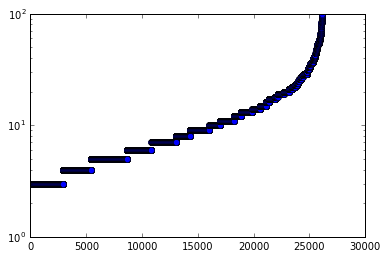

In [88]:
%matplotlib inline
plt.semilogy(sorted(np.sum(Dataframe2[:,3:6],axis=1)),'o')